In [1]:
import sys
sys.path.append('..')

import adabmDCA

In [2]:
import torch
from utils import one_hot
import matplotlib.pyplot as plt

In [3]:
import utils, selex_dca, indep_sites

/Users/scrotti/projects/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
from tqdm.autonotebook import tqdm

In [4]:
import selex_distribution, energy_models, tree, sampling, data_loading

In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, sampling, data_loading

import torch
from utils import one_hot
import matplotlib.pyplot as plt

: 

In [139]:
import importlib
importlib.reload(selex_distribution)
importlib.reload(energy_models)

<module 'energy_models' from '/Users/scrotti/projects/Aptamer2025py/energy_models.py'>

In [10]:
q = 4
L = 45

k = torch.randn(L, q)
h = torch.randn(L, q)
J = torch.randn(L, q, L, q)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1],[1]])

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
ps = selex_distribution.MultiModeDistribution(potts, normalized=False)

# def perceptron(L):
#     return torch.nn.Sequential(
#         torch.nn.Linear(L*q, 1),
#         torch.torch.nn.Softmax(dim=0)
#     )

# nns = [energy_models.GenericEnergyModel(perceptron(L)) for _ in range(2)]
# ps = selex_distribution.MultiModeDistribution(*nns, normalized=False)

Nst = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

M = 100
x_ = torch.randint(q, (M, L))
x = one_hot(x_, num_classes=q)

In [11]:
chains = torch.zeros(M, L, q)
chains[:, :, 0] = 1

t = 1
def compute_energy(x):
    return Nst.compute_energy_up_to_round(x, t)

sampling.metropolis_step_uniform_sites(chains, compute_energy)
sampling.sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=10)

In [12]:
energies = [compute_energy(chains).mean().detach().numpy()]
N = 200
for i_ in tqdm(range(N)):
    sampling.sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=1, beta=10.0)
    energies.append(compute_energy(chains).mean().detach().numpy())

  0%|          | 0/200 [00:00<?, ?it/s]

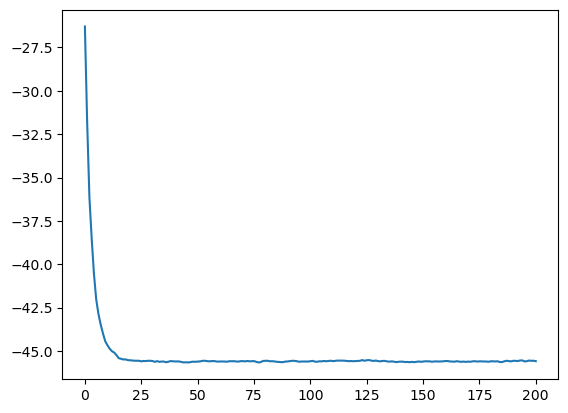

In [13]:
plt.plot(energies);

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from adabmDCA.utils import get_device, get_dtype


import sys
sys.path.append('..')
import selex_dca, utils
from utils import one_hot

In [16]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [17]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [18]:
sequences_oh = [one_hot(seq, num_classes=q).to(dtype) for seq in sequences]

In [19]:
def init_chains(
    n_rounds: int,
    n_chains: int,
    L: int,
    q: int,
    device: torch.device,
    dtype: torch.dtype | None = None,
) -> torch.Tensor:

    if dtype is None:
        dtype = torch.float32
    chains = [torch.randint(low=0, high=q, size=(n_chains, L), device=device)
            for _ in range(n_rounds)]
    
    chains_tensor = torch.stack([one_hot(c, num_classes=q).to(dtype) for c in chains])
    
    return chains_tensor   # n_rounds, n_chains, L, q

def compute_pearson(grad_model, grad_data):
    x = torch.nn.utils.parameters_to_vector(grad_model)
    y = torch.nn.utils.parameters_to_vector(grad_data)
    return torch.corrcoef(torch.stack([x, y]))[0, 1].item()

def compute_slope(grad_model, grad_data):
    x = torch.nn.utils.parameters_to_vector(grad_model)
    y = torch.nn.utils.parameters_to_vector(grad_data)
    n = len(x)
    num = n * (x @ y) - y.sum() * x.sum()
    den = n * (x @ x) - torch.square(x.sum())
    return torch.abs(num / den)

In [20]:
fi_tuple, fij_tuple, total_reads_tuple = zip(*[utils.frequences_from_sequences_oh(s) for s in sequences_oh])
fi = torch.stack(fi_tuple)  # n_rounds, L, q
fij = torch.stack(fij_tuple)      # n_rounds, L, q, L, q
total_reads = torch.tensor(total_reads_tuple, dtype=dtype)
n_rounds, L, q = fi.size()

In [21]:
Ri_tuple, Rij_tuple, total_reads_tuple = zip(*[utils.counts_from_sequences_oh(s) for s in sequences_oh])
Ri = torch.stack(Ri_tuple)  # n_rounds, L, q
Rij = torch.stack(Rij_tuple)      # n_rounds, L, q, L, q
total_reads = torch.tensor(total_reads_tuple, dtype=dtype)
Rtot = total_reads.sum()

In [ ]:
# normalized_total_reads = total_reads / total_reads.sum(0, keepdim=True)
# ts = torch.arange(len(normalized_total_reads))
# grad_data_cached = (
#     - Ri.sum(dim=0) / Rtot,
#     - (ts[:,None,None] * Ri).sum(dim=0) / Rtot
# )

In [22]:
def compute_grad_model_indep(model, normalized_total_reads):
    model.zero_grad()
    en = torch.zeros(1)
    for t in torch.arange(len(normalized_total_reads)):
        pi = (model.round_zero.h.detach().clone() + t * model.selection.modes[0].h.detach().clone()).exp()
        pi = pi / pi.sum(1, keepdim=True)
        pi = pi.unsqueeze(0)
        en = en + model.compute_energy_up_to_round(pi, t-1).mean() * normalized_total_reads[t]
    en.backward()
    gr = tuple([p.grad for p in model.parameters()])
    return gr

In [23]:
class ConvergenceMetricsCallback:
    def __init__(self, progress_bar=True):
        self.pearson = []
        self.slope = []
        self.grad_norm = []
        self.log_likelihood = []

    def __call__(self, grad_model, grad_data, grad_total, log_likelihood, target_pearson, thresh_slope, *args, **kwargs):
        pearson = compute_pearson(grad_model, grad_data)
        slope = compute_slope(grad_model, grad_data)
        grad_vec = torch.nn.utils.parameters_to_vector(grad_total)
        grad_norm = torch.sqrt(torch.square(grad_vec).sum()) / len(grad_vec)
        self.pearson.append(pearson)
        self.slope.append(slope)
        self.grad_norm.append(grad_norm)
        self.log_likelihood.append(log_likelihood.detach().numpy())
        
        c1 = pearson > target_pearson
        c2 = abs(slope - 1.) < thresh_slope

        return c1 and c2
    
    def plot(self, figsize=(10,3)):
        fig, axes = plt.subplots(1, 4, figsize=figsize)

        ax = axes[0]
        ax.plot([abs(1-p) for p in self.pearson])
        ax.set_yscale('log')
        ax.set_xlabel('iter')
        ax.set_ylabel('|1-pearson|')

        ax = axes[1]
        ax.plot([abs(1-p) for p in self.slope])
        ax.set_yscale('log')
        ax.set_xlabel('iter')
        ax.set_ylabel('|1-slope|')

        ax = axes[2]
        ax.plot(self.grad_norm)
        ax.set_yscale('log')
        ax.set_xlabel('iter')
        ax.set_ylabel('|| grad logL ||')

        ax = axes[3]
        ax.plot([-nll for nll in self.log_likelihood])
        ax.set_xlabel('iter')
        ax.set_ylabel('NLL')

        fig.tight_layout()
        
        return fig, axes
    
class PearsonCovarianceCallback:
    def __init__(self):
        self.pearson = []

    def __call__(self, grad_model, grad_data, total_reads, *args, **kwargs):
        fi = grad_data[1]
        fij = grad_data[2]
        pi = grad_model[1]
        pij = grad_model[2]
        pearson, slope = selex_dca.get_correlation_two_points(fij, pij, fi, pi, total_reads)
        self.pearson.append(pearson)

        return False
    
    def plot(self, figsize=(6, 3)):
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(self.pearson)
        ax.set_xlabel('iter')
        ax.set_ylabel('Pearson $C_{ij}$')

        return fig, ax


In [62]:
from tqdm.autonotebook import tqdm

def update_chains(chains, t, model, n_sweeps):
    compute_energy = lambda x : model.compute_energy_up_to_round(x, t)
    sampling.sample_metropolis_uniform_sites(torch.select(chains, 0, t), compute_energy, n_sweeps)

def compute_moments_model_at_round(model, chains, t):
    # this L is not physically a likelihood, more like a computational trick
    return model.compute_energy_up_to_round(chains, t).mean()

def compute_moments_data_at_round(model, data_batch, t):
    # this L is not physically a likelihood, more like a computational trick
    return model.compute_energy_up_to_round(data_batch, t).mean()

def compute_grad_model(model, L_model, retain_graph):
    params = tuple(model.parameters())

    grad_model = torch.autograd.grad(
        outputs=L_model,
        inputs=params,
        retain_graph=retain_graph,
        create_graph=False
    )

    return grad_model

def compute_grad_data(model, L_data, retain_graph):
    params = tuple(model.parameters())

    grad_data = torch.autograd.grad(
        outputs=L_data,
        inputs=params,
        retain_graph=retain_graph,
        create_graph=False
    )

    return grad_data

def compute_total_gradient(model, grad_model, grad_data):
    grad_total = tuple(-(gm - ge) for gm, ge in zip(grad_model, grad_data))
    
    with torch.no_grad():
        for p, g in zip(model.parameters(), grad_total):
            p.grad = g

    return grad_total


def train(
    model: selex_distribution.MultiRoundDistribution,
    data_loaders,
    total_reads,
    chains: torch.Tensor,
    n_sweeps: int,
    lr: float,    
    max_epochs: int,
    target_pearson = 0.999,
    thresh_slope = 1e-2,
    l2reg: float = 0.0,
    log_weights: torch.Tensor | None = None,
    callbacks = [ConvergenceMetricsCallback()],
    progress_bar: bool = True,
):
    n_rounds = len(data_loaders)
    assert chains.shape[0] == n_rounds
    normalized_total_reads = total_reads / total_reads.sum(0, keepdim=True)

    n_chains = chains.shape[1] 
    device=chains.device
    dtype=chains.dtype
    log_n_chains = torch.log(torch.tensor(n_chains, device=device, dtype=dtype)).item()

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=l2reg)

    log_likelihood = log_n_chains
    if log_weights is None:
        log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)

    epochs = 0   
    converged = (epochs > max_epochs)

    epochs = 0
    if progress_bar: 
        pbar = tqdm(
            initial=0,
            total=max_epochs,
            colour="red",
            dynamic_ncols=True,
            leave=False,
            ascii="-#",
            bar_format="{desc} {percentage:.2f}%[{bar}] Epoch: {n}/{total_fmt} [{elapsed}, {rate_fmt}{postfix}]"
        )
    while not converged:
        optimizer.zero_grad()
        L_model = L_data = 0
        log_likelihood = 0
        for t in range(n_rounds):
            # update chains
            update_chains(chains, t, model, n_sweeps)
            # compute gradient
            L_m = compute_moments_model_at_round(model, chains[t].clone(), t)
            L_model = L_model + normalized_total_reads[t] * L_m
            
            # extract batch of data from round t
            data_batch = next(iter(data_loaders[t]))
            L_d = compute_moments_data_at_round(model, data_batch, t)
            L_data = L_data + normalized_total_reads[t] * L_d
            logZt = (torch.logsumexp(log_weights[t], dim=0)).item() - log_n_chains
            log_likelihood += normalized_total_reads[t] * (- L_d - logZt)
        
            # TODO: compute round-wise convergence metrics

        # Compute gradient
        grad_model = compute_grad_model(model, L_model, retain_graph=True)
        # grad_model = compute_grad_model_indep(model)
        # grad_data = grad_data_cached
        grad_data = compute_grad_data(model, L_data, retain_graph=False)
        grad_total = compute_total_gradient(model, grad_model, grad_data)
        # do gradient step on params
        optimizer.step()

        # callbacks
        for callback in callbacks:
            c = callback(model=model, chains=chains, total_reads=total_reads, 
                         log_likelihood = log_likelihood,
                         grad_model=grad_model, grad_data=grad_data, grad_total=grad_total,
                         target_pearson=target_pearson, thresh_slope=thresh_slope)
            converged = converged or c


        epochs += 1
        if progress_bar:
            pbar.n = epochs
            pbar.set_description(f"Epoch {epochs}, Pearson = {callbacks[0].pearson[-1]:.4e}, Gradient norm = {callbacks[0].grad_norm[-1]:.4e}")

In [32]:
normalized_total_reads = total_reads / total_reads.sum(0, keepdim=True)
ts = torch.arange(len(normalized_total_reads))
model.zero_grad()
for t in ts:
    en = compute_moments_data_at_round(model, sequences_oh[t], t)
    en_avg = en.mean()
    loss_t = en_avg * normalized_total_reads[t]
    loss_t.backward()

if model.round_zero.h.grad is None:
    model.round_zero.h.grad = torch.zeros_like(model.round_zero.h)
    
grad_data_cached = tuple([p.grad if not p.grad is None else torch.zeros_like(h) for p in model.parameters()])
model.zero_grad()

In [63]:
k = torch.zeros(L, q)
h = torch.zeros(L, q)
# k = fi[0].clone().log()
J = torch.zeros(L, q, L, q)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1],[1]])

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [64]:
n_chains = 10**4

datasets = [data_loading.SelexRoundDataset(seq_oh) for seq_oh in sequences_oh]
n_rounds = len(datasets) 
callbacks = [ConvergenceMetricsCallback(), PearsonCovarianceCallback()]
chains = init_chains(n_rounds, n_chains, L, q, device)
log_weights = torch.zeros(n_rounds, n_chains, device=chains.device, dtype=chains.dtype)

In [65]:
batch_size = 10**6
data_loaders = [torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True) for ds in datasets]

## TODO
A ogni classe assegnare dei metodi calcola media empirica, calcola media modello, che defaultano a usare le batch/chains ma altrimenti fanno una cosa piu efficiente
Metropolis efficiente per modelli fattorizzati

Trovare buon batch size calcolando l'energia con diversi batch e guardando deviazione

In [66]:
n_sweeps = 10
lr = 0.01
max_epochs = 1000

train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs,
      log_weights=log_weights, callbacks=callbacks, progress_bar=True)

 0.00%[          ] Epoch: 0/1000 [00:00, ?it/s]

KeyboardInterrupt: 

(<Figure size 600x300 with 1 Axes>,
 <Axes: xlabel='iter', ylabel='Pearson $C_{ij}$'>)

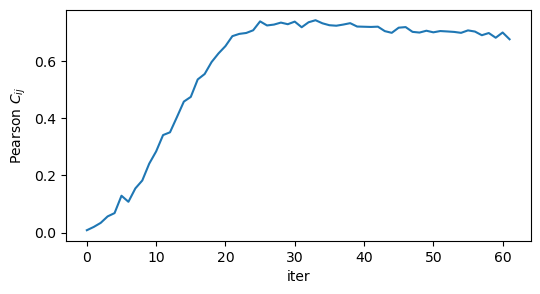

In [67]:
callbacks[1].plot()

(<Figure size 1000x300 with 4 Axes>,
 array([<Axes: xlabel='iter', ylabel='|1-pearson|'>,
        <Axes: xlabel='iter', ylabel='|1-slope|'>,
        <Axes: xlabel='iter', ylabel='|| grad logL ||'>,
        <Axes: xlabel='iter', ylabel='NLL'>], dtype=object))

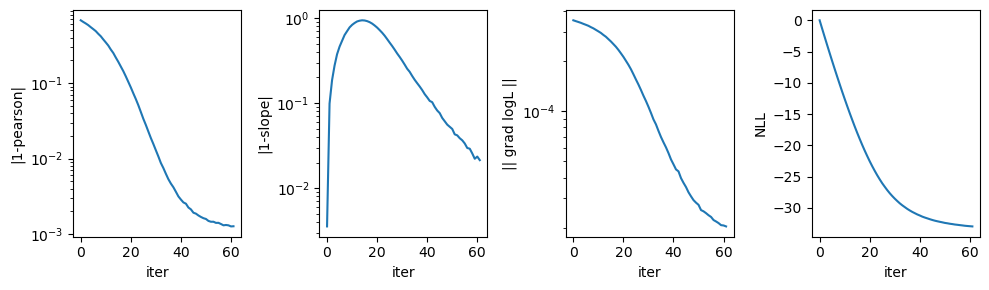

In [68]:
callbacks[0].plot()

In [806]:
history_indep = indep_sites.init_history()
params=indep_sites.init_parameters(fi)

params, history_indep = indep_sites.train(
    fi = fi,
    total_reads = total_reads,
    params = params,
    lr = 1e-2,    
    max_epochs = 5*10**4,
    target_error = 1e-12,
    history = history_indep,
    progress_bar = False
)

In [807]:
params = utils.set_zerosum_gauge(params)
h_indep = params['bias_ps']
k_indep = params['bias_Ns0']

In [815]:
potts = model.selection.modes[0].set_zerosum_gauge()
ns0 = model.round_zero.set_zerosum_gauge()
h_model = potts.h.detach().numpy()
k_model = ns0.h.detach().numpy()

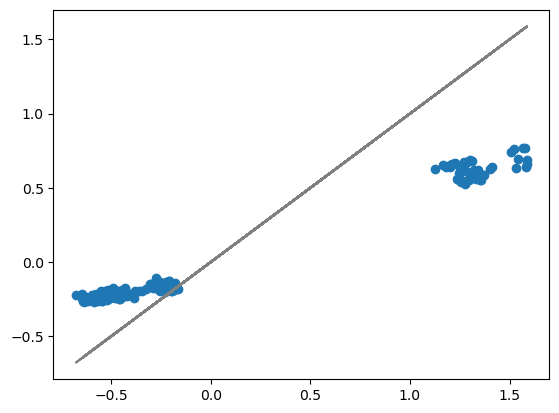

In [809]:
plt.scatter(k_indep, k_model)
plt.plot(k_indep, k_indep, color='gray');

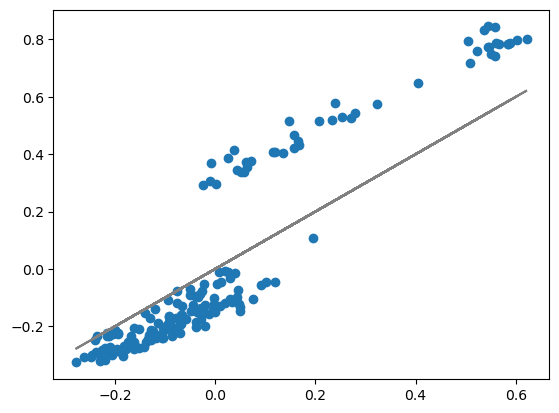

In [819]:
plt.scatter(h_indep, h_model)
plt.plot(h_indep, h_indep, color='gray');

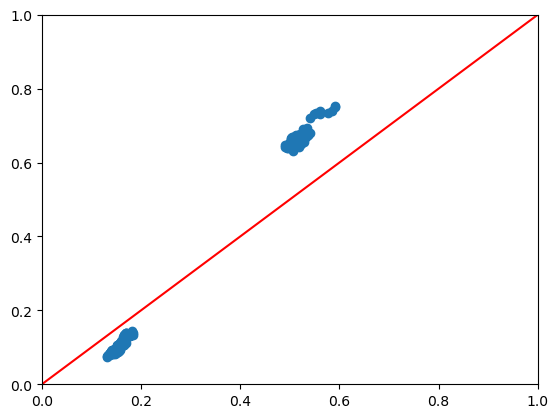

In [820]:
pi = history["pi"][-1]
x = pi.view(-1)
y = fi[0].view(-1)
plt.scatter(x, y)
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot((0,1), (0,1), color='red')

NameError: name 'potts_zerosum' is not defined

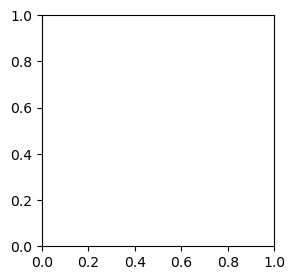

In [ ]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))